2025-05-13 11:13:47.025475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747134827.048079    4099 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747134827.055058    4099 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 38.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
🔍 Extracting ELAMO features...
📊 Applying SMOTE on full data...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747134850.093382    4099 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



🧠 Training and evaluating model on test set each epoch:

🔁 Epoch 1/20


I0000 00:00:1747134854.066104    4155 service.cc:148] XLA service 0x785acc0029c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747134854.066138    4155 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747134854.361784    4155 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747134856.826491    4155 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


📉  Loss: 0.8008 | 🎯 Accuracy: 0.7100 | 🧪 F1-score: 0.7045
🔁 Epoch 2/20
📉  Loss: 0.7163 | 🎯 Accuracy: 0.7349 | 🧪 F1-score: 0.7278
🔁 Epoch 3/20
📉  Loss: 0.6739 | 🎯 Accuracy: 0.7504 | 🧪 F1-score: 0.7436
🔁 Epoch 4/20
📉  Loss: 0.6475 | 🎯 Accuracy: 0.7627 | 🧪 F1-score: 0.7549
🔁 Epoch 5/20
📉  Loss: 0.6179 | 🎯 Accuracy: 0.7698 | 🧪 F1-score: 0.7628
🔁 Epoch 6/20
📉  Loss: 0.5930 | 🎯 Accuracy: 0.7786 | 🧪 F1-score: 0.7727
🔁 Epoch 7/20
📉  Loss: 0.5746 | 🎯 Accuracy: 0.7830 | 🧪 F1-score: 0.7773
🔁 Epoch 8/20
📉  Loss: 0.5645 | 🎯 Accuracy: 0.7886 | 🧪 F1-score: 0.7829
🔁 Epoch 9/20
📉  Loss: 0.5557 | 🎯 Accuracy: 0.7910 | 🧪 F1-score: 0.7869
🔁 Epoch 10/20
📉  Loss: 0.5441 | 🎯 Accuracy: 0.7997 | 🧪 F1-score: 0.7947
🔁 Epoch 11/20
📉  Loss: 0.5296 | 🎯 Accuracy: 0.8046 | 🧪 F1-score: 0.7995
🔁 Epoch 12/20
📉  Loss: 0.5242 | 🎯 Accuracy: 0.8050 | 🧪 F1-score: 0.8004
🔁 Epoch 13/20
📉  Loss: 0.5139 | 🎯 Accuracy: 0.8044 | 🧪 F1-score: 0.7980
🔁 Epoch 14/20
📉  Loss: 0.4990 | 🎯 Accuracy: 0.8141 | 🧪 F1-score: 0.8102
🔁 Epoch 15/20


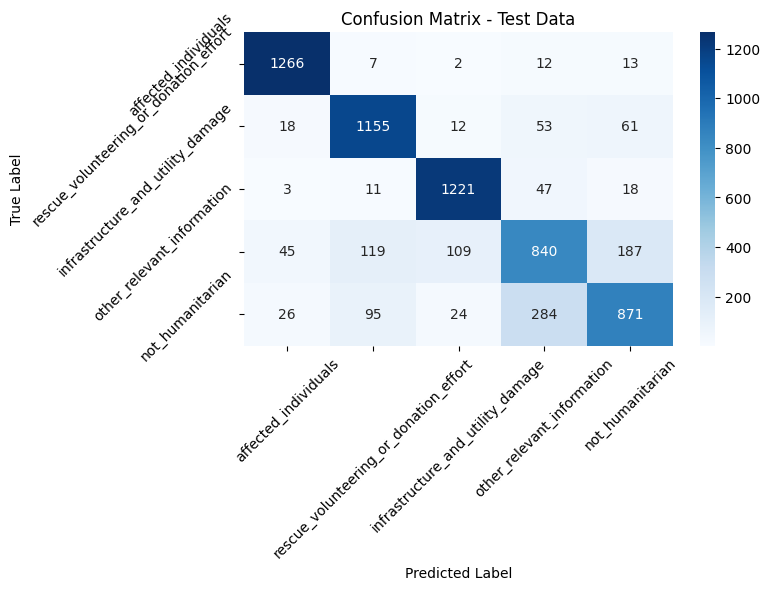

✅ Model saved as 'elamo_humanitarian_cnn_model.h5'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from collections import Counter

# Load spaCy model
import spacy.cli
spacy.cli.download("en_core_web_md")
nlp = spacy.load("en_core_web_md")

# Load main dataset
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Clean and prepare data
df.columns = df.columns.str.strip().str.lower()
df['processed_data'] = df['processed_data'].fillna("")
df['humanitarian_class'] = df['humanitarian_class'].fillna("not_humanitarian").str.strip().str.lower()

# Label encoding
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}
df['label'] = df['humanitarian_class'].map(label_map)

# Extract ELAMO features on full dataset
def extract_elamo_features(texts):
    lexical_vectors = []
    pos_counts = []
    lemma_counts = []

    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        if doc.has_vector:
            lexical_vectors.append(doc.vector)
        else:
            lexical_vectors.append(np.zeros(nlp.vocab.vectors_length))

        pos_tags = [token.pos_ for token in doc]
        lemmas = [token.lemma_ for token in doc]
        pos_counts.append([len(set(pos_tags))])
        lemma_counts.append([len(set(lemmas))])

    return np.hstack((lexical_vectors, pos_counts, lemma_counts))

print("🔍 Extracting ELAMO features...")
X = extract_elamo_features(df['processed_data'])
y = df['label'].values

# Apply SMOTE on full data
print("📊 Applying SMOTE on full data...")
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Split into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

# Build CNN model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Track best epoch
best_f1 = 0
best_model_weights = None

# Training loop with test set evaluation per epoch
EPOCHS = 20
BATCH_SIZE = 128

print("\n🧠 Training and evaluating model on test set each epoch:\n")
for epoch in range(EPOCHS):
    print(f"🔁 Epoch {epoch + 1}/{EPOCHS}")
    model.fit(X_train, y_train_cat, batch_size=BATCH_SIZE, epochs=1, verbose=0)

    # Evaluate on test
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    loss = model.evaluate(X_test, y_test_cat, verbose=0)[0]

    print(f"📉  Loss: {loss:.4f} | 🎯 Accuracy: {acc:.4f} | 🧪 F1-score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_model_weights = model.get_weights()

# Restore best weights
model.set_weights(best_model_weights)
print("\n✅ Best model (based on F1-score) loaded.")

# Final evaluation
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎉 Final Test Accuracy: {acc:.4f}")
print("📋 Final Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Save model
model.save("elamo_humanitarian_cnn_model.h5")
print("✅ Model saved as 'elamo_humanitarian_cnn_model.h5'")
